In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier

# Загрузка данных

In [2]:
class Loader:
    def __init__(self):
        self.data = pd.read_csv(r"iris.csv")[0:100]

        le = preprocessing.LabelEncoder()
        self.data['species'] = le.fit_transform(self.data['species'])

        X = self.data.drop(['species'], axis=1)
        y = self.data['species']

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25, random_state=24)

In [3]:
loader = Loader()
X_train, X_test, y_train, y_test = loader.X_train, loader.X_test, loader.y_train, loader.y_test

# Метрики

In [4]:
#accuracy

def accuracy(y_test, y_pred):
    compare_df = pd.DataFrame({'y': list(y_test), 'y_pred': y_pred})
    
    TP = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 1)]
    FP = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 1)]
    FN = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 0)]
    TN = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 0)]
    
    return (len(TP) + len(TN)) / len(compare_df)

#precession

def precession(y_test, y_pred):
    compare_df = pd.DataFrame({'y': (y_test), 'y_pred': y_pred})
    
    TP = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 1)]
    FP = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 1)]
    FN = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 0)]
    TN = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 0)]
    
    return len(TP) / (len(TP) + len(FP))

#recall

def recall(y_test, y_pred):
    compare_df = pd.DataFrame({'y': list(y_test), 'y_pred': y_pred})
    
    TP = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 1)]
    FP = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 1)]
    FN = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 0)]
    TN = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 0)]
    
    return len(TP) / (len(TP) + len(FN))
                                    
#f1

def f1(y_test, y_pred):
    compare_df = pd.DataFrame({'y': list(y_test), 'y_pred': y_pred})
    
    TP = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 1)]
    FP = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 1)]
    FN = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 0)]
    TN = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 0)]
    
    precession_ = precession(y_test, y_pred)
    recall_ = recall(y_test, y_pred)
    return 2 * precession_ * recall_ / (recall_+ precession_)

# Линейный классификатор

In [7]:
class LinearClassifier:
    def __init__(self):
        self.weights = None
        self.v = None
        self.num_samples = None
        self.num_features = None
        self.loss = None
        self.learning_rate = None
        self.delta = None
        self.momentum = None
        self.lambda_reg = None
        self.optimizer = None
        self.t = None
        self.M = None
        self.w = None

    def __call__(self, lr, a, lambda_reg, delta, optimizer, t, w, M=False):
        self.learning_rate = lr
        self.delta = delta
        self.momentum = a
        self.lambda_reg = lambda_reg
        self.optimizer = optimizer
        self.t = t
        self.M = M
        self.w = w

    def init_weights(self, X, y):
        if self.w == 'corr':
            X = np.array(X)
            f = np.sum(X, axis=0)
            self.weights = np.sum(y) * f / (f * f)
            self.v = np.zeros(self.num_features) * 0.01
        else:
            self.weights = np.random.rand(self.num_features) * 0.01
            self.v = np.zeros(self.num_features) * 0.01

    def fit(self, X, y):
        if self.w != 'multi':
            self.feedforward(X, y)
        else:
            loss = []
            w = []

            for i in range(5):
                self.feedforward(X, y)
                loss.append(np.mean(self.loss))
                w.append(self.weights)

            min_loss = 1
            for _ in loss:
                if _ < min_loss:
                    min_loss = _

            self.weights = w[loss.index(min_loss)]

    def feedforward(self, X, y):
        self.num_samples, self.num_features = X.shape
        self.init_weights(X, y)

        X = np.array(X)
        y_ = np.where(np.array(y) <= 0, -1, 1)

        q = [self.count_q(X, y_), self.count_q(X, y_)]

        median = None
        q1 = None
        q3 = None
        if self.M is True:
            g = self.margin(X, y_)
            g = [abs(_) for _ in g]
            median = g.index(float(np.median(g)))

            elem = g[0]
            delta = 0.000001

            num = float(np.quantile(g, 0.25))
            for _ in g:
                if _ - num < delta:
                    elem = _
            q1 = g.index(elem)
            num = float(np.quantile(g, 0.75))
            for _ in g:
                if _ - num < delta:
                    elem = _
            q3 = g.index(elem)

        self.loss = []

        while abs(q[-1] - q[-2]) > self.delta:
            if self.M is False:
                i = randint(0, self.num_samples - 1)
            else:
                i = randint(0, self.num_samples - 1)
                if i < q1:
                    i = randint(0, q1)
                elif q1 < i < median:
                    i = randint(q1, median)
                elif median > i > q3:
                    i = randint(median, q3)
                else:
                    i = randint(median, self.num_samples - 1)

            X_butch = X[i]
            y_butch = y_[i]

            M = self.count_margin(X_butch, y_butch)
            self.loss.append((1 - M) ** 2)

            dloss = self.dcount_margin(X_butch, y_butch)
            grad_w = self.backward(X_butch, y_butch, dloss)
            self.update_params(grad_w, X_butch)

            q.append(self.lambda_reg * M + (1 - self.lambda_reg) * q[-1])

    def count_margin(self, X, y):
        return np.dot(self.weights, X.T) * y

    def dcount_margin(self, X, y):
        return - 2 * (1 - self.count_margin(X, y))

    @staticmethod
    def backward(X, y, dloss):
        grad_w = np.dot(X, dloss) * y
        return grad_w

    def update_params(self, grad_w, X):
        if self.optimizer == 'momentum':
            self.v = self.momentum * self.v - self.learning_rate * grad_w
            self.weights += self.v
        elif self.optimizer == 'l2':
            self.weights -= (grad_w + self.weights * self.t) * self.learning_rate
        elif self.optimizer == 'fast':
            self.learning_rate = 1.0 / (np.sum(X * X) + 1e-8)
            self.weights -= grad_w * self.learning_rate
        else:
            self.weights -= grad_w * self.learning_rate

    def predict(self, X):
        X = np.array(X)
        pred = []
        for i in range(len(X)):
            linear_output = np.dot(X[i], self.weights) - 0.1
            pred.append(int(self.sign(linear_output)))
        return pd.Series(np.where(np.array(pred) >= 0, 1, 0))

    @staticmethod
    def sign(x):
        return np.where(x >= 0, 1, -1)

    def count_q(self, X, y):
        i = randint(0, self.num_samples-1)
        return self.count_margin(X[i], y[i])

    def margin(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = np.array(X)
            y = np.where(np.array(y) <= 0, -1, 1)

        self.num_samples, self.num_features = X.shape
        g = []
        self.init_weights(X, y)

        for i in range(self.num_samples):
            X_butch = X[i]
            y_butch = y[i]

            g.append(float((np.dot(X_butch, self.weights)) * y_butch))
        return g

    @staticmethod
    def visualize(X, y):
        X = np.array(X)
        y = np.where(np.array(y) <= 0, -1, 1)
        
        num_samples, num_features = X.shape
        g = []
        weights = np.random.rand(num_features)

        for i in range(num_samples):
            X_butch = X[i]
            y_butch = y[i]

            g.append(float((np.dot(X_butch, weights)) * y_butch))

        # Визуализация данных
        plt.figure(figsize=(10, 6))

        # Отображение точек данных
        for i in range(len(y)):
            if y[i] == 1:
                plt.scatter(X[i][0], X[i][1], color='blue', marker='o',
                            label='1' if '1' not in plt.gca().get_legend_handles_labels()[1] else "")
            else:
                plt.scatter(X[i][0], X[i][1], color='red', marker='x',
                            label='-1' if '-1' not in plt.gca().get_legend_handles_labels()[1] else "")

        # Визуализация границы принятия решения
        x_values = np.linspace(min(X[:, 0]) - 1, max(X[:, 0]) + 1, X.shape[0])
        g.sort()
        y_values = g
        plt.plot(x_values, y_values, color='green', label='Граница')

        plt.title('Отступ')
        plt.grid(color='gray', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()

# Визаулизация отступа

In [8]:
classifier = LinearClassifier()

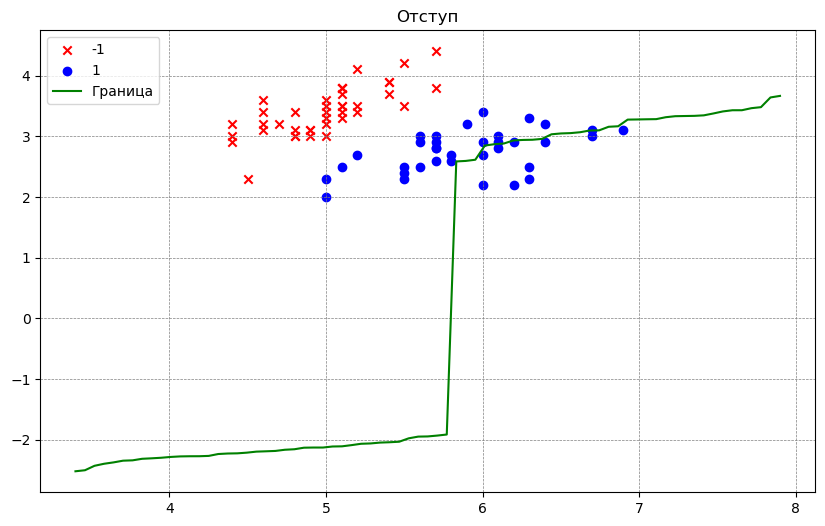

In [9]:
classifier.visualize(X_train, y_train)

# SG

In [38]:
%%time
classifier(lr=0.01, a=0.01, lambda_reg=0.0001, delta=0.0000001, optimizer='sgd', t=0.9, M=False, w='random')
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
print(f'Accuracy: {accuracy(y_test, pred)}')
print(f'Precession: {precession(y_test, pred)}')
print(f'Recall: {recall(y_test, pred)}')
print(f'F1: {f1(y_test, pred)}')

Accuracy: 1.0
Precession: 1.0
Recall: 1.0
F1: 1.0
CPU times: total: 93.8 ms
Wall time: 122 ms


# Momentum

In [39]:
%%time
classifier(lr=0.01, a=0.01, lambda_reg=0.0001, delta=0.0000001, optimizer='momentum', t=0.9, M=False, w='random')
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
print(f'Accuracy: {accuracy(y_test, pred)}')
print(f'Precession: {precession(y_test, pred)}')
print(f'Recall: {recall(y_test, pred)}')
print(f'F1: {f1(y_test, pred)}')

Accuracy: 1.0
Precession: 1.0
Recall: 1.0
F1: 1.0
CPU times: total: 62.5 ms
Wall time: 64.3 ms


# L2

In [40]:
%%time
classifier(lr=0.01, a=0.01, lambda_reg=0.0001, delta=0.0000001, optimizer='l2', t=0.9, M=False, w='random')
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
print(f'Accuracy: {accuracy(y_test, pred)}')
print(f'Precession: {precession(y_test, pred)}')
print(f'Recall: {recall(y_test, pred)}')
print(f'F1: {f1(y_test, pred)}')

Accuracy: 1.0
Precession: 1.0
Recall: 1.0
F1: 1.0
CPU times: total: 15.6 ms
Wall time: 49.3 ms


# Fast

In [41]:
%%time
classifier(lr=0.01, a=0.01, lambda_reg=0.0001, delta=0.0000001, optimizer='fast', t=0.9, M=False, w='random')
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
print(f'Accuracy: {accuracy(y_test, pred)}')
print(f'Precession: {precession(y_test, pred)}')
print(f'Recall: {recall(y_test, pred)}')
print(f'F1: {f1(y_test, pred)}')

Accuracy: 1.0
Precession: 1.0
Recall: 1.0
F1: 1.0
CPU times: total: 78.1 ms
Wall time: 124 ms


# Отступ по модулю

In [42]:
%%time
classifier(lr=0.01, a=0.01, lambda_reg=0.0001, delta=0.0000001, optimizer='sgd', t=0.9, M=True, w='random')
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
print(f'Accuracy: {accuracy(y_test, pred)}')
print(f'Precession: {precession(y_test, pred)}')
print(f'Recall: {recall(y_test, pred)}')
print(f'F1: {f1(y_test, pred)}')

Accuracy: 1.0
Precession: 1.0
Recall: 1.0
F1: 1.0
CPU times: total: 62.5 ms
Wall time: 196 ms


# Инициализация весов через корреляцию

In [44]:
%%time
classifier(lr=0.01, a=0.01, lambda_reg=0.0001, delta=0.0000001, optimizer='sgd', t=0.9, M=False, w='corr')
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
print(f'Accuracy: {accuracy(y_test, pred)}')
print(f'Precession: {precession(y_test, pred)}')
print(f'Recall: {recall(y_test, pred)}')
print(f'F1: {f1(y_test, pred)}')

Accuracy: 1.0
Precession: 1.0
Recall: 1.0
F1: 1.0
CPU times: total: 125 ms
Wall time: 275 ms


# Мультистарт

In [45]:
%%time
classifier(lr=0.01, a=0.01, lambda_reg=0.0001, delta=0.0000001, optimizer='sgd', t=0.9, M=False, w='multi')
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
print(f'Accuracy: {accuracy(y_test, pred)}')
print(f'Precession: {precession(y_test, pred)}')
print(f'Recall: {recall(y_test, pred)}')
print(f'F1: {f1(y_test, pred)}')

Accuracy: 1.0
Precession: 1.0
Recall: 1.0
F1: 1.0
CPU times: total: 93.8 ms
Wall time: 521 ms


# Библиотека

In [48]:
%%time
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=20)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f'Accuracy: {accuracy(y_test, pred)}')
print(f'Precession: {precession(y_test, pred)}')
print(f'Recall: {recall(y_test, pred)}')
print(f'F1: {f1(y_test, pred)}')

Accuracy: 1.0
Precession: 1.0
Recall: 1.0
F1: 1.0
CPU times: total: 0 ns
Wall time: 25.8 ms
